In [45]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
from rvi_sampling.utils.stochastic_processes import create_SIR, ArbitriaryPrior, SIRParameters
import numpy as np
from collections import namedtuple
import torch.nn as nn
import torch
from rvi_sampling.stochastic_processes.base import PyTorchWrap
from rvi_sampling.samplers import RVISampler
from pg_methods.networks import MLP_factory
from pg_methods.policies import MultinomialPolicy
from pg_methods.baselines import MovingAverageBaseline, NeuralNetworkBaseline
from pg_methods.objectives import PolicyGradientObjective
A = namedtuple('bla', 'sir_seed')
import seaborn as sns
sns.set_style('whitegrid')

In [126]:
prior = ArbitriaryPrior(np.array([[98, 2], [99, 1], [97, 3], [96, 4], [95, 5]]))
process_parameters = SIRParameters(100, 10, 0.9, 200, 0.01)
fake_argparser = A(0)
sir, _ = create_SIR(fake_argparser, sir_params=process_parameters, n_agents=1, prior=prior)

In [127]:
sir.xT

array([ 0, 39])

In [128]:
# create a policy for the RVI sampler
fn_approximator = MLP_factory(sir.state_space+int(1),
                              hidden_sizes=[32, 32, 32],
                              output_size=sir.action_space,
                              hidden_non_linearity=nn.ReLU)

policy = MultinomialPolicy(fn_approximator)
policy_optimizer = torch.optim.RMSprop(fn_approximator.parameters(),lr=0.001)
baseline = MovingAverageBaseline(0.99)

# fn_approximator2 = MLP_factory(sir.state_space+int(1),
#                               hidden_sizes=[16, 16],
#                               output_size=1,
#                               hidden_non_linearity=nn.ReLU)
# value_fn_optimizer = torch.optim.RMSprop(fn_approximator2.parameters(),lr=0.001)
# baseline = NeuralNetworkBaseline(fn_approximator2, value_fn_optimizer)

rvi =  RVISampler(policy,
                  policy_optimizer,
                  baseline=baseline,
                  objective=PolicyGradientObjective(entropy=10, time_mean=False),
                  feed_time=True,
                  seed=0)

In [129]:
results = rvi.solve(PyTorchWrap(sir), 2000, verbose=True)

/home/ml/zahmed8/dev/better-sampling/rvi_sampling/stochastic_processes/epidemiology.py:183: RuntimeWarning: divide by zero encountered in log
  step_log_probs = np.log(step_probs)
/home/ml/zahmed8/dev/better-sampling/rvi_sampling/stochastic_processes/epidemiology.py:183: RuntimeWarning: invalid value encountered in log
  step_log_probs = np.log(step_probs)


MC Sample 0, loss -2.72468e+07, episode_reward -400036, trajectory_length 103, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -93.58792394399643
MC Sample 100, loss -1407.16, episode_reward -100056, trajectory_length 115, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -73.80277732014656
MC Sample 200, loss 239.892, episode_reward -100035, trajectory_length 112, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -75.83831283450127
MC Sample 300, loss -1210.52, episode_reward -100044, trajectory_length 132, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -91.38321542739868
MC Sample 400, loss -30147.4, episode_reward -200049, trajectory_length 49, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -12.063513069122564
MC Sample 500, loss -76724.6, episode_reward -200028, trajectory_length 84, successful trajs 0, path_log_prob: -inf, proposal_log_prob: -46.493589093210176
MC Sample 600, loss -21.2138, episode_reward -100034, trajector

In [18]:
#[traj[0] for traj in results.all_trajectories()]

In [23]:
# results.plot_trajectory_evolution(dimension=0)
# results.plot_trajectory_evolution(dimension=1)

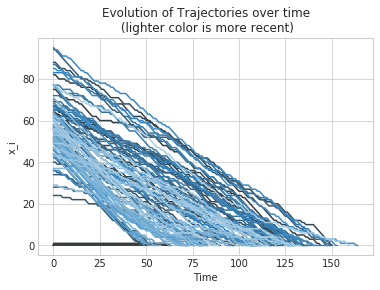

In [130]:
results.plot_all_trajectory_evolution(dimension=0)

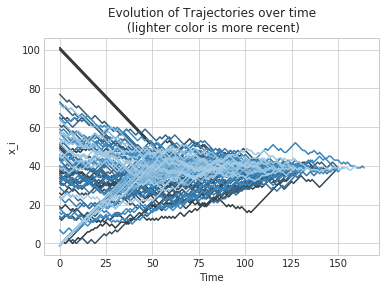

In [132]:
results.plot_all_trajectory_evolution(dimension=1)

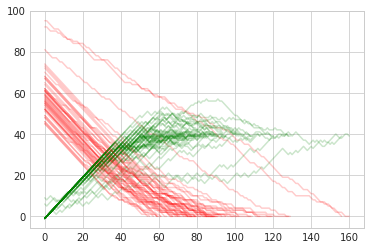

In [135]:
for trajectory in results.all_trajectories()[-50:]:
#     print(trajectory[0])
    plt.plot(trajectory[:, 0], label='Susceptibles', color='r', alpha=0.2)
    plt.plot(trajectory[:, 1], label='infecteds', color='g', alpha=0.2)
#     if np.any(trajectory <0): print('TRAJ <0')
#     plt.plot(sir.population_size - trajectory[:, 0] - trajectory[:, 1], label='recoveries', color='b', alpha=0.2)


array([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200])

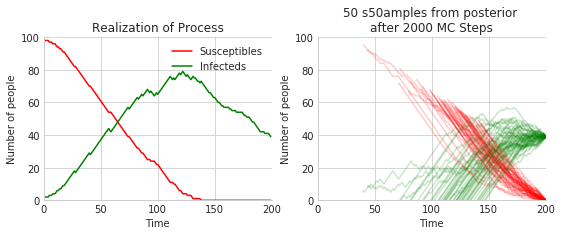

In [149]:
fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(121)
ax.plot(sir.true_trajectory[:, 0], label='Susceptibles', color='r')
ax.plot(sir.true_trajectory[:, 1], label='Infecteds', color='g')
ax.set_xlabel('Time')
ax.set_ylabel('Number of people')
ax.legend()
ax.set_ylim(0, 100)
ax.set_xlim(0, 200)
ax.set_title('Realization of Process')

ax = fig.add_subplot(122)
for trajectory in results.all_trajectories()[-50:]:
    ax.plot(np.arange(200-trajectory.shape[0]+1, 201, 1), trajectory[:, 0], label='Susceptibles', color='r', alpha=0.2)
    ax.plot(np.arange(200-trajectory.shape[0]+1, 201, 1), trajectory[:, 1], label='infecteds', color='g', alpha=0.2)
ax.set_xlabel('Time')
ax.set_ylabel('Number of people')
ax.set_ylim(0, 100)
ax.set_xlim(0, 200)
ax.set_title('50 s50amples from posterior \nafter 2000 MC Steps')
sns.despine()

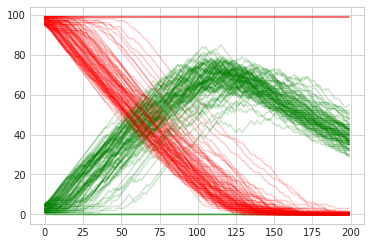

In [121]:
for i in range(100):
    trajectory = sir.simulate()
    plt.plot(trajectory[:, 0], label='Susceptibles', color='r', alpha=0.2)
    plt.plot(trajectory[:, 1], label='infecteds', color='g', alpha=0.2)
#     plt.plot(sir.population_size - trajectory[:, 0] - trajectory[:, 1], label='recoveries', color='b', alpha=0.2)
